## Import packages and specify local GPU for training

In [2]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim

import EWOthello.utils.plot_helpers as plt_util
from EWOthello.data.othello import *
from EWOthello.mingpt.dataset import ProbingDataset, CharDataset # AK's mingpt data child 
from EWOthello.mingpt.model import GPT, GPTConfig, GPTforProbing, GPTforProbing_v2
from EWOthello.mingpt.probe_trainer import Trainer, TrainerConfig
from EWOthello.mingpt.utils import set_seed, sample # AKs helpers for sampling predictions
from EWOthello.mingpt.probe_model import BatteryProbeClassification
set_seed(44)

print(torch.cuda.is_available())
device = torch.cuda.current_device()
print(torch.cuda.get_device_name(device))

True
NVIDIA GeForce RTX 3090 Ti


## Test Generation of Probe Datasets

In [3]:
othello = get(ood_num=-1, data_root=None, num_preload=11) # 11 corresponds to over 1 million games
game_dataset = CharDataset(othello) 

Max num files: 230; Use_num: 11
['gen10e5__20220324_165952.pickle', 'gen10e5__20220324_154919.pickle', 'gen10e5__20220324_164123.pickle', 'gen10e5__20220324_154043.pickle', 'gen10e5__20220324_155251.pickle', 'gen10e5__20220324_160016.pickle', 'gen10e5__20220324_165748.pickle', 'gen10e5__20220324_154002.pickle', 'gen10e5__20220324_155241.pickle', 'gen10e5__20220324_165707.pickle', 'gen10e5__20220324_160046.pickle']


Mem Used: 1.059 GB: 100%|██████████| 11/11 [00:01<00:00,  5.82it/s]


Deduplicating...
Deduplicating finished with 1099941 games left
Using 20 million for training, 0 for validation
Dataset created has 1099941 sequences, 61 unique words.


  0%|          | 0/1099941 [00:00<?, ?it/s]


59
59
[19, 18, 17, 9, 1]
['c4', 'c3', 'c2', 'b2', 'a2']


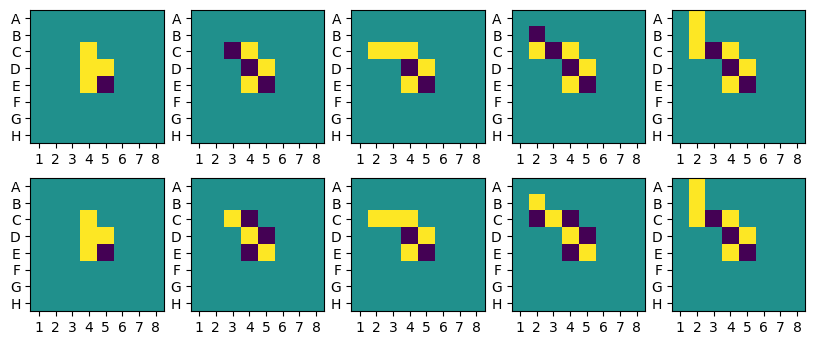

In [3]:
mconf = GPTConfig(game_dataset.vocab_size, game_dataset.block_size, n_layer=8, n_head=8, n_embd=512)
model_probe = GPTforProbing(mconf, probe_layer=6)
mode = "synthetic"

if mode=="random":
    model = GPT(mconf)
    model_probe.apply(model._init_weights)
else:
    path = "../EWOthello/ckpts/gpt_championship.ckpt" if mode=="championship" else "../EWOthello/ckpts/gpt_synthetic.ckpt"
    model_probe.load_state_dict(torch.load(path))
    
if torch.cuda.is_available():
    model_probe = model_probe.to(device)

#########
### Test the code to get the probe dataset
properties_modifier_matrix = np.ones((59, 64))
for i in range(59):
    if i % 2 == 1:
        properties_modifier_matrix[i, :] *= -1.0

property_container_v2 = []
property_container = []
act_container = []
for x, _ in tqdm(game_dataset):
    # Convert the game index sequence to board number sequence for use with the othello board class
    tbf = [game_dataset.itos[_] for _ in x.tolist()]
    valid_until = tbf.index(-100) if -100 in tbf else 999

    # Get the board state vectors
    a = OthelloBoardState()
    properties = a.get_gt(tbf[:valid_until], "get_state")
    property_container.extend(properties)
    properties_v2 = (np.array(properties) - 1.0) * properties_modifier_matrix[:valid_until, :] + 1.0
    property_container_v2.extend(properties_v2.tolist())

    # Get the activation vectors
    act = model_probe(x[None, :].to(device))[0].detach().cpu().split(1, dim=0)    
    act_container.extend(act)
    break
print(len(property_container_v2))
print(len(act_container))

# Visualize the board state before and after modification
num_disp = 5
print(tbf[:num_disp])
print(plt_util.seq_to_boardCoord(tbf[:num_disp]))

fig = plt.figure(figsize=(num_disp*2, 4))
ax = plt_util.addAxis(fig, 2, num_disp)
for i in range(num_disp):
    ax[i].imshow(np.reshape(property_container[i], [8,8]))
    ax[i+num_disp].imshow(np.reshape(property_container_v2[i], [8,8]))

plt_util.format_ax_boardImage(ax)

## Run Training for GPT Linear Probes

In [4]:
class probe_dataset(Dataset):
    def __init__(self, game_dataset, probe_layer, property_type="new"):
        self.game_dataset = game_dataset
        self.property_type = property_type # 'old' vs 'new'
        self.property_modifier = np.concatenate([np.ones((1,64))*(-1)**i for i in range(59)],axis=0)

        # Define the GPT probe model to return activations
        mconf = GPTConfig(game_dataset.vocab_size, game_dataset.block_size, n_layer=8, n_head=8, n_embd=512)
        GPT_probe = GPTforProbing(mconf, probe_layer=probe_layer)
        GPT_probe.load_state_dict(torch.load("../EWOthello/ckpts/gpt_synthetic.ckpt"))
        for param in GPT_probe.parameters():
            param.requires_grad = False
        GPT_probe.eval()
        self.GPT_probe = GPT_probe.to(device)
    
    def __len__(self):
        return len(self.game_dataset)

    def __getitem__(self, index):
        x, _ = self.game_dataset[index]
        tbf = [game_dataset.itos[_] for _ in x.tolist()]
        valid_until = tbf.index(-100) if -100 in tbf else 999

        # Get the board state vectors
        a = OthelloBoardState()
        board_state = a.get_gt(tbf[:valid_until], "get_state")
        if self.property_type=="new":
            board_state = (np.array(board_state) - 1.0) * self.property_modifier[:valid_until, :] + 1.0

        # Get the activation vectors
        act = self.GPT_probe(x[None, :].to(device))[0, :valid_until, :].detach().cpu()
        
        return act, torch.tensor(board_state, dtype=torch.float32)

In [5]:
othello = get(ood_num=-1, data_root=None, num_preload=10) # 11 corresponds to over 1 million games
game_dataset = CharDataset(othello) 

Max num files: 230; Use_num: 10
['gen10e5__20220324_165952.pickle', 'gen10e5__20220324_154919.pickle', 'gen10e5__20220324_164123.pickle', 'gen10e5__20220324_154043.pickle', 'gen10e5__20220324_155251.pickle', 'gen10e5__20220324_160016.pickle', 'gen10e5__20220324_165748.pickle', 'gen10e5__20220324_154002.pickle', 'gen10e5__20220324_155241.pickle', 'gen10e5__20220324_165707.pickle']


Mem Used: 1.686 GB: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Deduplicating...
Deduplicating finished with 999947 games left
Using 20 million for training, 0 for validation
Dataset created has 999947 sequences, 61 unique words.


In [6]:
def train_linear_probe(probe_layer, savepath, property_type="new", num_epochs=1, save_at_steps=100, verbose=False):
    training_data = probe_dataset(game_dataset, probe_layer=probe_layer, property_type=property_type)
    probe = BatteryProbeClassification(device, probe_class=3, num_task=64, input_dim=512)
    train_ratio = 0.8
    batch_size = 512 #Batch over number of games (each game has 59 max moves played)
    learning_rate = 0.01
    model_name = f"linearProbe_Map_{property_type}_8L8H_GPT_Layer{probe_layer}"

    def my_collate_fn(batch):
        xstack = []
        ystack = []
        for batchit in batch:
            xstack.append(batchit[0])
            ystack.append(batchit[1])
        
        x =  torch.cat(xstack, dim=0)
        y = torch.cat(ystack, dim=0)
        return (x,y)

    train_size = int(train_ratio * len(training_data))
    test_size = len(training_data) - train_size
    train_dataset, test_dataset = random_split(training_data, [train_size, test_size])
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)
    test_iter = iter(test_dataloader)
    optimizer = optim.Adam(probe.parameters(), lr=learning_rate)
    training_loss_history = []
    testing_loss_history = []
    testing_board_accuracy = []

    print(f"Training Model Name: {model_name}; training/test set size {train_size}/{test_size}")
    if os.path.exists(savepath + model_name + ".ckpt"):
        probe.load_state_dict(torch.load(savepath + model_name + ".ckpt"))
        print(f"Loaded model checkpopint from {savepath + model_name + '.ckpt'}")
        with open(savepath + model_name + ".pickle", 'rb') as fhandle:
            training_history = pickle.load(fhandle)
            training_loss_history = training_history["training_loss"]
            testing_loss_history = training_history["testing_loss"]
            testing_board_accuracy = training_history["testing_board_acc"]

    for epoch in range(num_epochs):
        #for i, (x,y) in tqdm(enumerate(train_dataloader)):
        i = 0
        for (x,y) in tqdm(train_dataloader):
            ### Train the Probe
            probe.train()
            x = x.to(device)
            y = y.to(device)

            logits, loss = probe(x, y)
            train_loss = loss.item()
            training_loss_history.append(train_loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ### Compute the error on validation batch
            probe.eval()
            with torch.no_grad():
                try:
                    x,y = next(test_iter)
                except:
                    test_iter = iter(test_dataloader)
                    x,y = next(test_iter)

                x = x.to(device)
                y = y.to(device)        
                logits, loss = probe(x,y)
                test_loss = loss.item()
                testing_loss_history.append(test_loss)

                y_hat = torch.argmax(logits, dim=-1, keepdim=False)  # [B, #task]
                mean_board_acc = torch.mean(torch.sum(y_hat == y ,-1)/64).item()
                testing_board_accuracy.append(mean_board_acc)

            ### Print update
            i = i + 1
            if verbose:
                print(f'step [{i+1}/{len(train_dataloader)}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Avg. Board Acc. Test {mean_board_acc:.3f}')

            if (i+1) % save_at_steps == 0:
                print("Saving Model Checkpoint")
                torch.save(probe.state_dict(), savepath + model_name + ".ckpt")
                training_history = {"training_loss": training_loss_history, "testing_loss": testing_loss_history, "testing_board_acc": testing_board_accuracy}
                with open(savepath + model_name + ".pickle", 'wb') as fhandle:
                    pickle.dump(training_history, fhandle)

    return

In [7]:
savepath = "/home/deanhazineh/Research/emergent_world_representation/EWOthello/ckpts/DeanModels/"
for probe_layer in [1, 2, 3, 4, 5]:
    train_linear_probe(probe_layer, savepath, property_type="new")
    #train_linear_probe(probe_layer, savepath, property_type="old")

Training Model Name: linearProbe_Map_new_8L8H_GPT_Layer1; training/test set size 799957/199990


  6%|▋         | 99/1563 [03:09<45:57,  1.88s/it] 

Saving Model Checkpoint


  7%|▋         | 102/1563 [03:15<46:07,  1.89s/it]